In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline


from tensorflow.keras.preprocessing.image import load_img
import tensorflow as tf
#from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [94]:
BASE_DIR = '/kaggle/input/dataset'

In [95]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/9 [00:00<?, ?it/s]

In [96]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/kaggle/input/dataset/48_1_0_103.jpg.chip.jpg,48,1
1,/kaggle/input/dataset/22_0_0_107.jpg.chip.jpg,22,0
2,/kaggle/input/dataset/54_0_0_102.jpg.chip.jpg,54,0
3,/kaggle/input/dataset/22_0_0_106.jpg.chip.jpg,22,0
4,/kaggle/input/dataset/20_1_0_104.jpg.chip.jpg,20,1


In [97]:
gender_dict = {0:'Male', 1:'Female'}
df.head()

,image,age,gender
0,/kaggle/input/dataset/48_1_0_103.jpg.chip.jpg,48,1
1,/kaggle/input/dataset/22_0_0_107.jpg.chip.jpg,22,0
2,/kaggle/input/dataset/54_0_0_102.jpg.chip.jpg,54,0
3,/kaggle/input/dataset/22_0_0_106.jpg.chip.jpg,22,0
4,/kaggle/input/dataset/20_1_0_104.jpg.chip.jpg,20,1


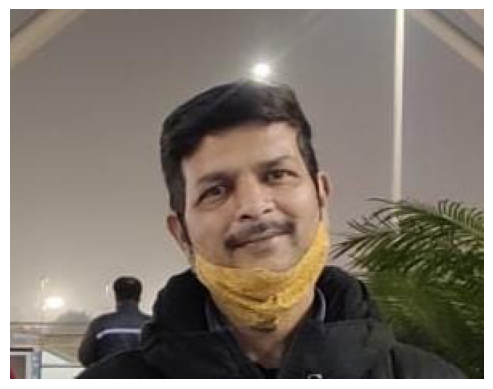

In [98]:
from PIL import Image
img = Image.open(df['image'][7])
plt.axis('off')
plt.imshow(img);

<AxesSubplot:xlabel='age', ylabel='Density'>

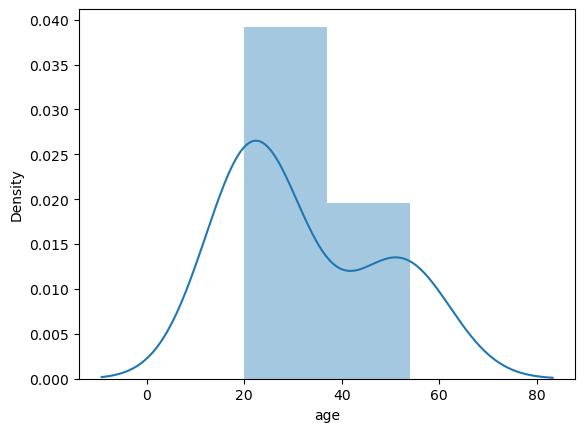

In [99]:
sns.distplot(df['age'])

<AxesSubplot:ylabel='count'>

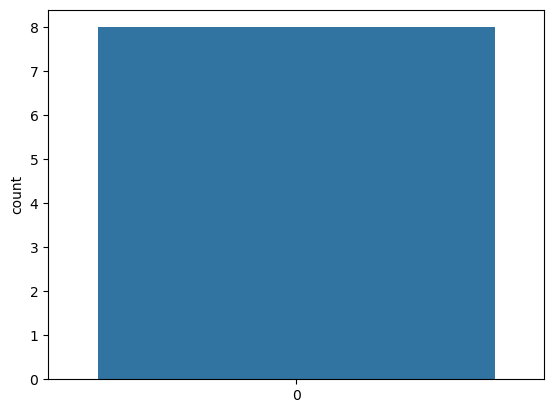

In [92]:
sns.countplot(df['gender'])

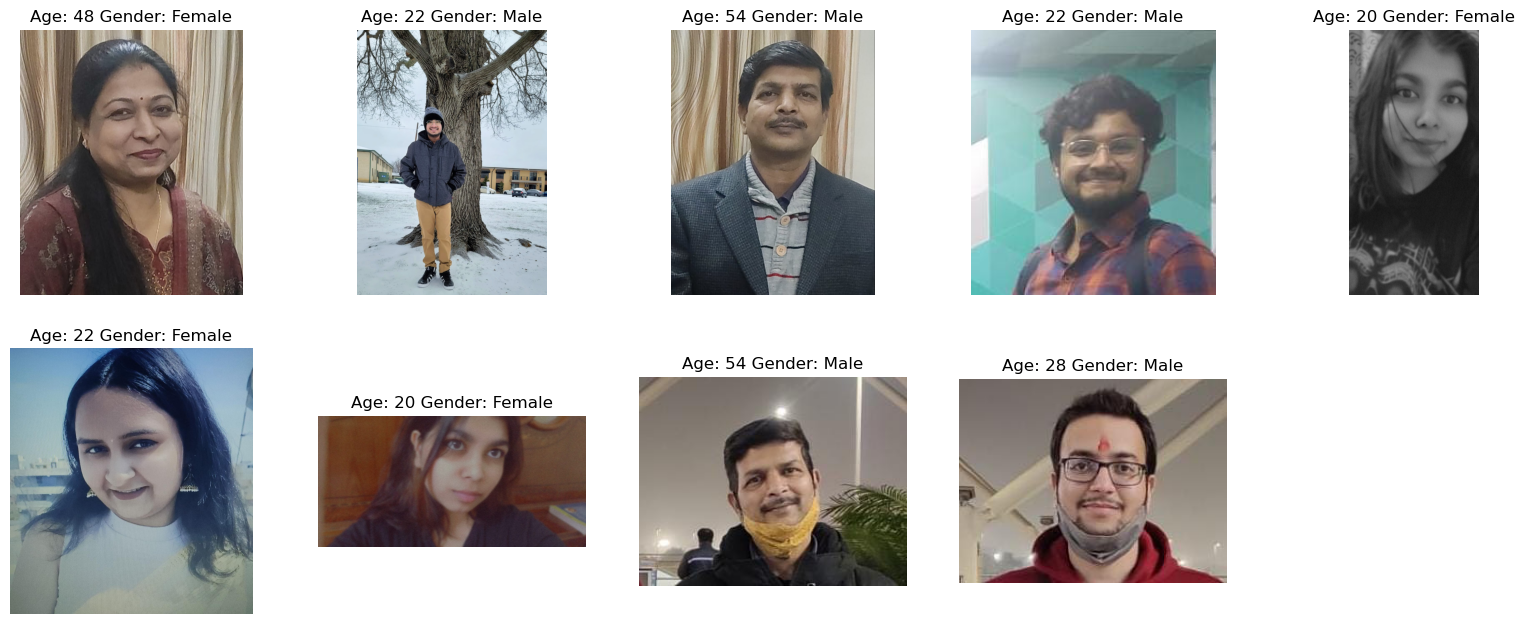

In [100]:
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [101]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [102]:
X = extract_features(df['image'])

  0%|          | 0/9 [00:00<?, ?it/s]

In [103]:
X.shape

(9, 128, 128, 1)

In [104]:
X = X/255.0

In [105]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [107]:
input_shape = (128, 128, 1)

In [63]:
inputs = Input((input_shape))
# convulational layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layer
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [108]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 126, 126, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 63, 63, 32)  0           ['conv2d_4[0][0]']               
                                                                                            

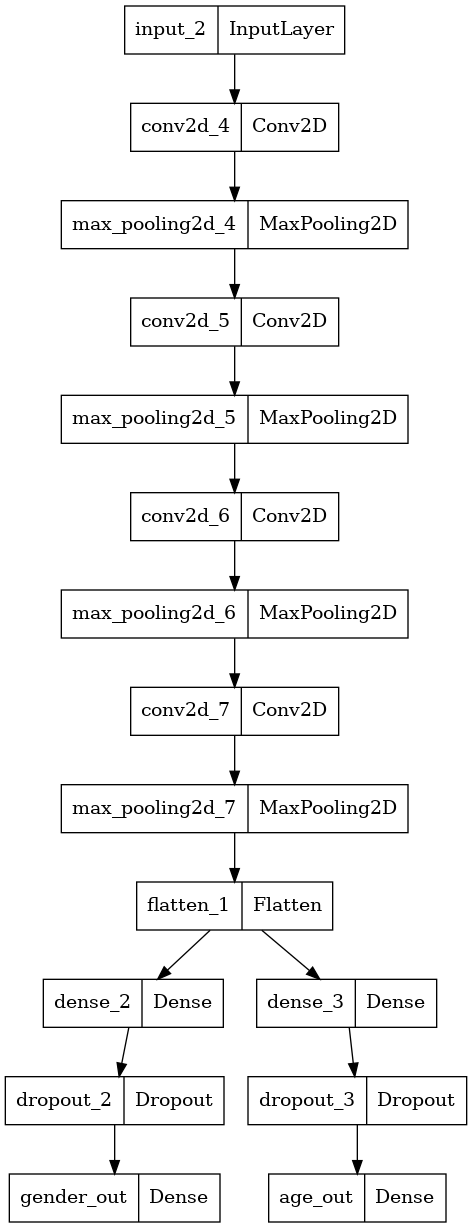

In [109]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [110]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=15, validation_split=0.2)

Epoch 1/15
1/1 [==============================] - 0s 326ms/step - loss: 152.9481 - gender_out_loss: 2.1947 - age_out_loss: 150.7534 - gender_out_accuracy: 0.2857 - age_out_accuracy: 0.0000e+00 - val_loss: 97.2082 - val_gender_out_loss: 1.6429 - val_age_out_loss: 95.5653 - val_gender_out_accuracy: 0.0000e+00 - val_age_out_accuracy: 0.0000e+00
Epoch 2/15
1/1 [==============================] - 0s 230ms/step - loss: 93.8341 - gender_out_loss: 0.7664 - age_out_loss: 93.0677 - gender_out_accuracy: 0.5714 - age_out_accuracy: 0.0000e+00 - val_loss: 43.0685 - val_gender_out_loss: 1.3252 - val_age_out_loss: 41.7433 - val_gender_out_accuracy: 0.0000e+00 - val_age_out_accuracy: 0.0000e+00
Epoch 3/15
1/1 [==============================] - 0s 226ms/step - loss: 46.9351 - gender_out_loss: 0.7422 - age_out_loss: 46.1929 - gender_out_accuracy: 0.4286 - age_out_accuracy: 0.0000e+00 - val_loss: 14.3739 - val_gender_out_loss: 1.0387 - val_age_out_loss: 13.3352 - val_gender_out_accuracy: 0.0000e+00 - val_a

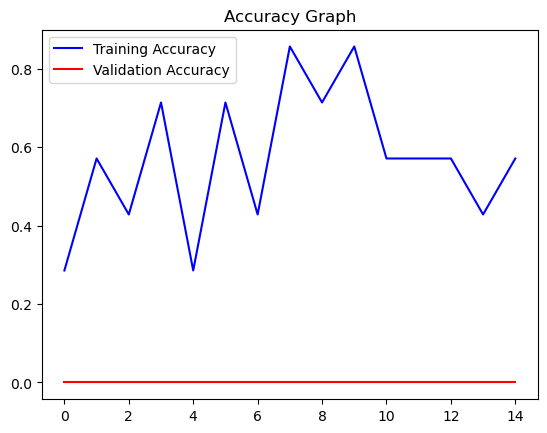

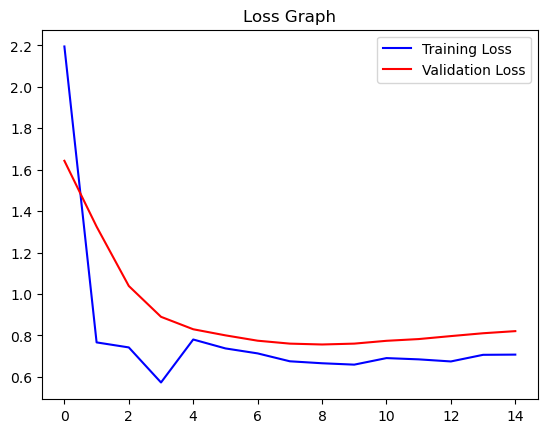

In [111]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

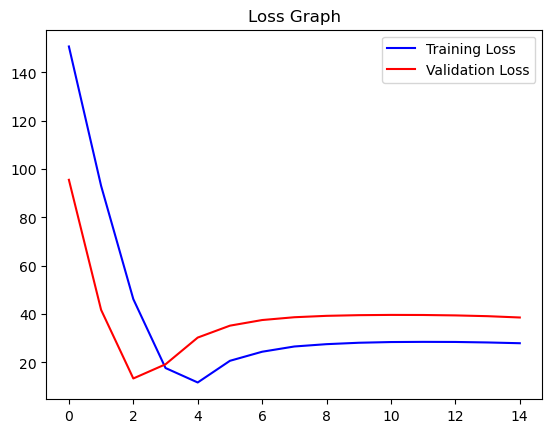

In [112]:
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender:  Female Original Age:  22
1/1 [==============================] - 0s 34ms/step
Predicted Gender:  Female Predicted Age:  2


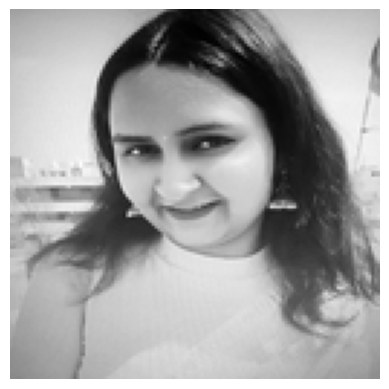

In [118]:
image_index = 5
print("Original Gender: ", gender_dict[y_gender[image_index]], "Original Age: ", y_age[image_index])
#predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender: ", pred_gender, "Predicted Age: ", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender:  Female Original Age:  20
1/1 [==============================] - 0s 32ms/step
Predicted Gender:  Male Predicted Age:  20


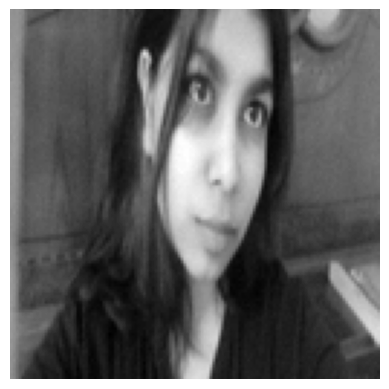

In [72]:
image_index = 3
print("Original Gender: ", gender_dict[y_gender[image_index]], "Original Age: ", y_age[image_index])
#predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender: ", pred_gender, "Predicted Age: ", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender:  Male Original Age:  22
1/1 [==============================] - 0s 32ms/step
Predicted Gender:  Male Predicted Age:  20


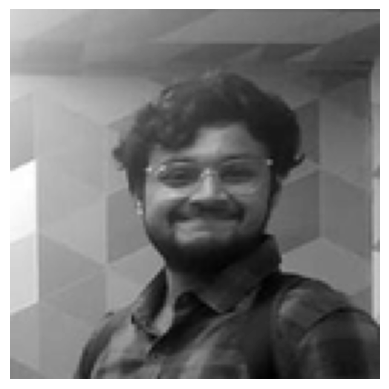

In [73]:
image_index = 4
print("Original Gender: ", gender_dict[y_gender[image_index]], "Original Age: ", y_age[image_index])
#predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender: ", pred_gender, "Predicted Age: ", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender:  Male Original Age:  28
1/1 [==============================] - 0s 33ms/step
Predicted Gender:  Male Predicted Age:  20


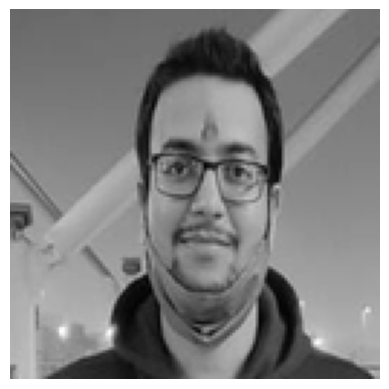

In [78]:
image_index = 7
print("Original Gender: ", gender_dict[y_gender[image_index]], "Original Age: ", y_age[image_index])
#predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender: ", pred_gender, "Predicted Age: ", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

In [81]:
image_index = 8
print("Original Gender: ", gender_dict[y_gender[image_index]], "Original Age: ", y_age[image_index])
#predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender: ", pred_gender, "Predicted Age: ", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

IndexError: index 8 is out of bounds for axis 0 with size 8